In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, Markdown

In [2]:
target_var = 'SeriousDlqin2yrs'

model_df = pd.read_csv('data_extracted/model.csv',
                      dtype={'SeriousDlqin2yrs': np.int8,
                             'age': np.int8,
                             'NumberOfTime30To59DaysPastDueNotWorse': np.int8,
                             'NumberOfTime60To89DaysPastDueNotWorse': np.int8,
                             'NumberOfTimes90DaysLate': np.int8,
                             'NumberOfOpenCreditLinesAndLoans': np.int8,
                             'NumberRealEstateLoansOrLines': np.int64})

test_df = pd.read_csv('data_extracted/test.csv',
                      dtype={'SeriousDlqin2yrs': np.int8,
                             'age': np.int8,
                             'NumberOfTime30To59DaysPastDueNotWorse': np.int8,
                             'NumberOfTime60To89DaysPastDueNotWorse': np.int8,
                             'NumberOfTimes90DaysLate': np.int8,
                             'NumberOfOpenCreditLinesAndLoans': np.int8,
                             'NumberRealEstateLoansOrLines': np.int64})

predict_df = pd.read_csv('data_extracted/predict.csv',
                         dtype={'age': np.int8,
                                'NumberOfTime30To59DaysPastDueNotWorse': np.int8,
                                'NumberOfTime60To89DaysPastDueNotWorse': np.int8,
                                'NumberOfTimes90DaysLate': np.int8,
                                'NumberOfOpenCreditLinesAndLoans': np.int8,
                                'NumberRealEstateLoansOrLines': np.int64})

print("Shapes: model {}, test {}".format(model_df.shape, test_df.shape))
print("Shapes: predict {}".format(predict_df.shape))

Shapes: model (104983, 11), test (45000, 11)
Shapes: predict (101503, 10)


## Analyzing data correlation

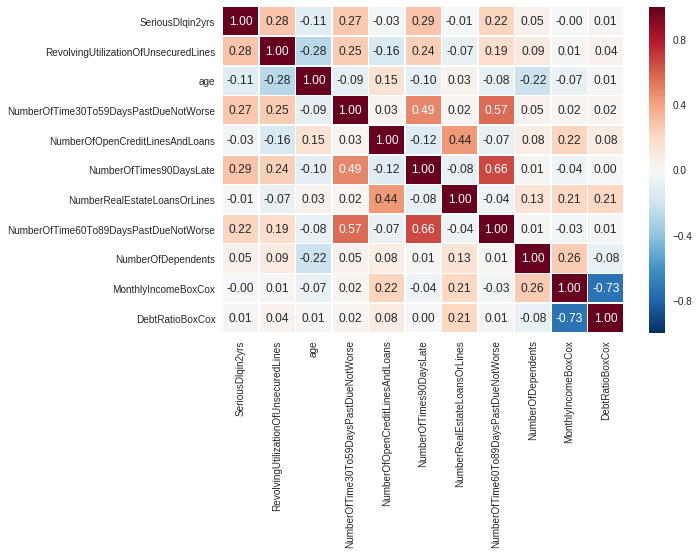

In [3]:
f, ax = plt.subplots(figsize=(9, 6))

corr = model_df.corr()

sns.heatmap(corr, annot=True, fmt="0.2f", linewidths=.5, vmin=-1, vmax=1, ax=ax)
plt.show()

There is high correlation between the target variable and:
-  NumberOfTimes90DaysLate, with 29%;
-  RevolvingUtilizationOfUnsecureLines, with 28%;
-  NumberOfTime30To59DaysPastDueNotWorse, with 27%;
-  NumberOfTime60To90DaysPastDueNotWorse, with 22%;
-  age, with -11%;
-  NumberOfDependents, with 5%.

## Analyzing pairplot

,real_name,short_name
0,SeriousDlqin2yrs,SeriousDlqin2yrs
1,F1,RevolvingUtilizationOfUnsecuredLines
2,F2,age
3,F3,NumberOfTime30To59DaysPastDueNotWorse
4,F4,NumberOfOpenCreditLinesAndLoans
5,F5,NumberOfTimes90DaysLate
6,F6,NumberRealEstateLoansOrLines
7,F7,NumberOfTime60To89DaysPastDueNotWorse
8,F8,NumberOfDependents
9,F9,MonthlyIncomeBoxCox


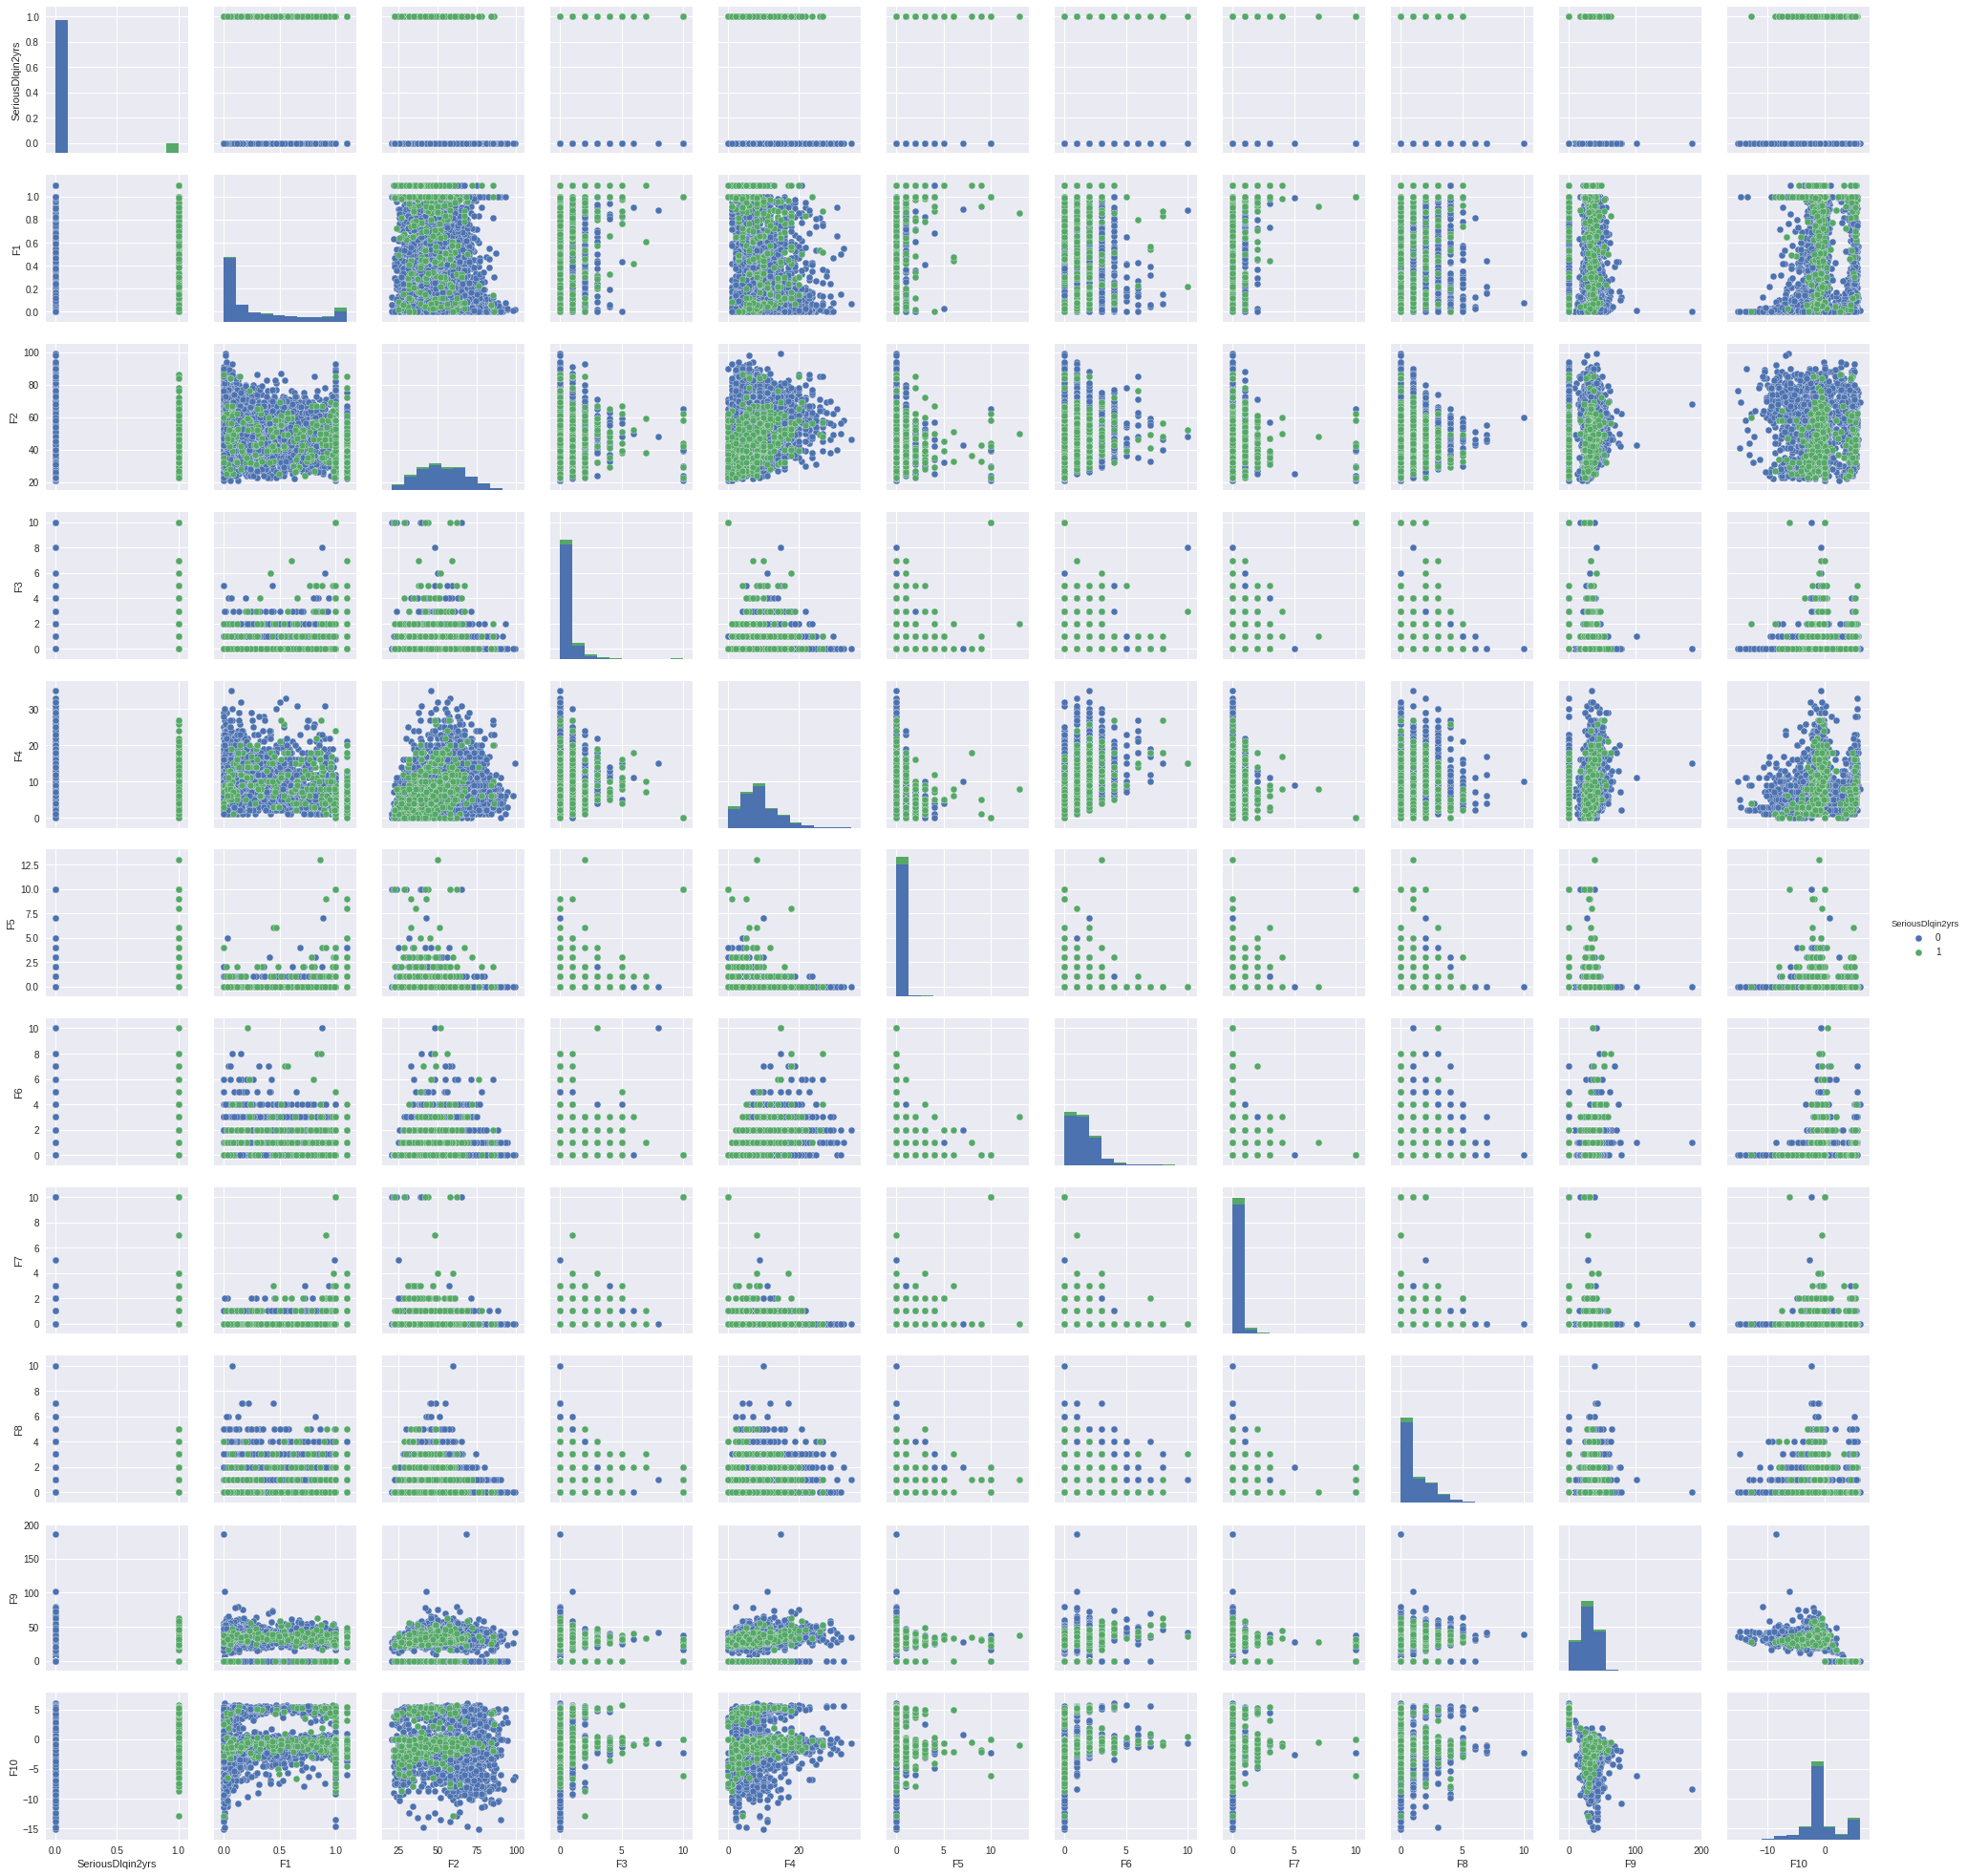

In [4]:
# sampling
sampled_data = model_df.groupby(target_var).apply(lambda grp: grp.sample(frac=0.04))

# renaming columns (to better fit of the plot)
old_column_names = sampled_data.columns
sampled_data.columns = [ "F" + str(idx) \
                        if col != target_var else target_var \
                        for idx, col in enumerate(old_column_names)]

# displaying names
display(pd.DataFrame({"real_name":sampled_data.columns.values,
                      "short_name": old_column_names.values}))

# plotting
sns.pairplot(sampled_data, hue='SeriousDlqin2yrs')
plt.show()

Some plots seems to be separable by some hyperplanes.

## Analyzing each feature separately by using a threshold

In [5]:
from sklearn.metrics import roc_auc_score

In [6]:
def best_threshold(df, feature, vals):
    res = np.empty((0, 2), np.float16)
    
    for val in vals:
        (val, roc) = predict_threshold(df, feature, val)
        res = np.vstack((res, [val, roc]))
    
    idx = np.argmax(res[:,1])
    
    return(res[idx])

In [7]:
def predict_threshold(df, feature, val):
    pred = np.zeros(sampled_data.shape[0], dtype=np.int8)
    pred = pd.Series(pred)
    pred[(sampled_data[feature].values <= val)] = 1
    
    roc = roc_auc_score(df['SeriousDlqin2yrs'].values, pred.values)
    if roc < 0.5:
        roc = 1 - roc
    
    return (val, roc)

In [62]:
# sampling
sampled_data = model_df.groupby(target_var).apply(lambda grp: grp.sample(frac=0.04))
features = sampled_data.columns.copy().drop(target_var)

thresh_res = pd.DataFrame(columns=['feat thresh ROC'.split()])

for (idx, feature) in enumerate(features):
    # obtaining possible thresholds by percentiles
    vals = np.unique(np.percentile(sampled_data[feature], range(100)))
    
    # calculating best threshold based on the roc curve
    thresh, roc = best_threshold(sampled_data, feature, vals)
    
    thresh_res.loc[idx] = [feature, thresh, roc]


display(thresh_res.sort_values('ROC', ascending=False))

,feat,thresh,ROC
0,RevolvingUtilizationOfUnsecuredLines,0.390115,0.733004
2,NumberOfTime30To59DaysPastDueNotWorse,0.000000,0.662902
4,NumberOfTimes90DaysLate,0.000000,0.651401
6,NumberOfTime60To89DaysPastDueNotWorse,0.000000,0.621832
1,age,54.000000,0.621362
5,NumberRealEstateLoansOrLines,0.000000,0.570922
8,MonthlyIncomeBoxCox,33.007646,0.566996
3,NumberOfOpenCreditLinesAndLoans,2.000000,0.557955
7,NumberOfDependents,1.000000,0.553774
9,DebtRatioBoxCox,-1.027752,0.531337


By just using one variable at time, and a simple thresold, we obtained reasonable values for the ROC score.

## Analyzing Logistic regression for pairs of features

In [9]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

/usr/local/lib/python2.7/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [20]:
import itertools

In [61]:
logit_res = pd.DataFrame(columns=['featA featB R2'.split()])

for (idx, (feat_a, feat_b)) in enumerate(itertools.combinations(features, 2)):
    formula = 'SeriousDlqin2yrs ~ {} + {}'.format(feat_a, feat_b)
    
    res = smf.logit(formula=formula, data=sampled_data).fit(disp=0)
    
    logit_res.loc[idx] = [feat_a, feat_b, res.prsquared]

display(logit_res.sort_values('R2', ascending=False).head(10))

,featA,featB,R2
3,RevolvingUtilizationOfUnsecuredLines,NumberOfTimes90DaysLate,0.193988
1,RevolvingUtilizationOfUnsecuredLines,NumberOfTime30To59DaysPastDueNotWorse,0.185439
5,RevolvingUtilizationOfUnsecuredLines,NumberOfTime60To89DaysPastDueNotWorse,0.175467
8,RevolvingUtilizationOfUnsecuredLines,DebtRatioBoxCox,0.153704
0,RevolvingUtilizationOfUnsecuredLines,age,0.153596
2,RevolvingUtilizationOfUnsecuredLines,NumberOfOpenCreditLinesAndLoans,0.153281
6,RevolvingUtilizationOfUnsecuredLines,NumberOfDependents,0.152845
7,RevolvingUtilizationOfUnsecuredLines,MonthlyIncomeBoxCox,0.152839
4,RevolvingUtilizationOfUnsecuredLines,NumberRealEstateLoansOrLines,0.152646
18,NumberOfTime30To59DaysPastDueNotWorse,NumberOfTimes90DaysLate,0.132242
